In [27]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.utils.data as data
import torch.nn.functional as functional

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import librosa
import IPython.display as ipd

from sklearn.model_selection import train_test_split
from scipy import spatial

def set_seed(seed = 1337):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
set_seed()

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/lawrence/workspace/pytorchenv/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['roots', 'copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
"""
audio_folder = '/home/lawrence/workspace/vad-experiments/dataset/LibriSpeech/train-clean-100/'

X = []
Y = []


        start = time.time()

        adjust_learning_rate(optimizeross_entropy(X_batch, Y_batch)
---> 15         loss.backward()
     16         optimizer.step()
speakers = os.listdir(audio_folder)
speaker2id = {}
flac_files = []
for speaker_id, speaker in enumerate(speakers):
    speaker2id[speaker] = speaker_id
    
for root, dirs, files in os.walk("/home/lawrence/workspace/vad-experiments/dataset/LibriSpeech/train-clean-100"):
    for file in files:
        if file.endswith(".flac"):
             flac_files.append(os.path.join(root, file))

for file_num, audio_file in enumerate(flac_files):
    speaker = os.path.basename(os.path.dirname(os.path.dirname(audio_file)))
    print(speaker)
    print(audio_file)
    y, sr = librosa.load(audio_file)
    print("asdf")
    num_samples = y.shape[0]
    int_seconds = num_samples//sr
    y = y[:int_seconds * sr]
    samples = np.array(np.split(y, int_seconds))
    mfccs = []
    for i in range(len(samples)):
        X.append(np.mean(librosa.feature.mfcc(y=samples[i], sr=sr, n_mfcc=40).T,axis=0))
    Y += [speaker2id[speaker]] * len(samples)
    print(file_num)
newX = np.array(X)
newY = np.array(Y).reshape(-1, 1)
np.save('Xvals_test.np', newX)
np.save('Yvals_test.np', newY)
"""

'\naudio_folder = \'/home/lawrence/workspace/vad-experiments/dataset/LibriSpeech/train-clean-100/\'\n\nX = []\nY = []\n\n\n        start = time.time()\n\n        adjust_learning_rate(optimizeross_entropy(X_batch, Y_batch)\n---> 15         loss.backward()\n     16         optimizer.step()\nspeakers = os.listdir(audio_folder)\nspeaker2id = {}\nflac_files = []\nfor speaker_id, speaker in enumerate(speakers):\n    speaker2id[speaker] = speaker_id\n    \nfor root, dirs, files in os.walk("/home/lawrence/workspace/vad-experiments/dataset/LibriSpeech/train-clean-100"):\n    for file in files:\n        if file.endswith(".flac"):\n             flac_files.append(os.path.join(root, file))\n\nfor file_num, audio_file in enumerate(flac_files):\n    speaker = os.path.basename(os.path.dirname(os.path.dirname(audio_file)))\n    print(speaker)\n    print(audio_file)\n    y, sr = librosa.load(audio_file)\n    print("asdf")\n    num_samples = y.shape[0]\n    int_seconds = num_samples//sr\n    y = y[:int_s

In [5]:
X = np.load('Xvals.np.npy')
Y = np.load('Yvals.np.npy').astype(numpy.int32)

def split_train_test_val(X, Y, test_size=10000, val_size=10000):
    train_test_size = test_size + val_size
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=train_test_size)
    X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=val_size)
    return X_train, X_test, X_val, np.squeeze(Y_train), np.squeeze(Y_test), np.squeeze(Y_val)

X_train, X_test, X_val, Y_train, Y_test, Y_val = split_train_test_val(X, Y)
print("Train size: ", X_train.shape)
print("Test size: ", X_test.shape)
print("Val size: ", X_val.shape)

Train size:  (327745, 40)
Test size:  (10000, 40)
Val size:  (10000, 40)


In [6]:
class VADDNN(nn.Module):
    def __init__(self, input_size=40, output_size=496, dropout=0.5):
        super(VADDNN, self).__init__()
        self.linear_1 = nn.Linear(input_size, 256)
        self.linear_2 = nn.Linear(256, 256)
        self.linear_3 = nn.Linear(256, 256)
        self.linear_4 = nn.Linear(256, 256)
        self.linear_5 = nn.Linear(256, output_size)
        self.dropout_1 = nn.Dropout(p=dropout)
        self.dropout_2 = nn.Dropout(p=dropout)
            
    def forward(self, x):
        out = {}
        out['h1'] = nn.functional.relu(self.linear_1(x))
        out['h2'] = nn.functional.relu(self.linear_2(out['h1']))
        out['h3'] = nn.functional.relu(self.linear_3(self.dropout_1(out['h2'])))
        out['h4'] = nn.functional.relu(self.linear_4(self.dropout_2(out['h3'])))
        out['out'] = nn.functional.relu(self.linear_5(out['h4']))
        return [out['h4'], out['out']]
    
class VADCNN(nn.Module):
    def __init__(self, input_size=40, output_size=496, dropout=0.5):
        super(VADDNN, self).__init__()
        self.linear_1 = nn.Linear(input_size, 256)
        self.linear_2 = nn.Linear(256, 256)
        self.linear_3 = nn.Linear(256, 256)
        self.linear_4 = nn.Linear(256, 256)
        self.linear_5 = nn.Linear(256, output_size)
        self.dropout_1 = nn.Dropout(p=dropout)
        self.dropout_2 = nn.Dropout(p=dropout)
            
    def forward(self, x):
        out = {}
        out['h1'] = nn.functional.relu(self.linear_1(x))
        out['h2'] = nn.functional.relu(self.linear_2(out['h1']))
        out['h3'] = nn.functional.relu(self.linear_3(self.dropout_1(out['h2'])))
        out['h4'] = nn.functional.relu(self.linear_4(self.dropout_2(out['h3'])))
        out['out'] = nn.functional.relu(self.linear_5(out['h4']))
        return [out['h4'], out['out']]

In [5]:
epoch_loss = []

In [6]:
BATCH_SIZE = 256
train_dataset = data.TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(Y_train))
dataloader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
def get_model_name(epoch):
    return 'model/VAD_DNN_epoch_{}.pkl'.format(epoch)

In [7]:
EPOCHS = 100
START_EPOCH = 100
if START_EPOCH == 0:    
    model = VADDNN()
    model.cuda()
else:
    model = torch.load(get_model_name(START_EPOCH))
model.train()
start_time = time.time()
optimizer = optim.SGD(model.parameters(), lr=1e-3 / 1000, momentum=0.9, weight_decay=1e-6)
for epoch in range(START_EPOCH + 1, EPOCHS + 1):
    total_loss = 0.0
    epoch_correct = 0
    epoch_size = 0
    for batch_id, (X_batch, Y_batch) in enumerate(dataloader):
        X_batch, Y_batch = autograd.Variable(X_batch.cuda()), autograd.Variable(Y_batch.cuda())
        optimizer.zero_grad()
        _, output = model(X_batch)
        loss = functional.cross_entropy(output, Y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss
        
        pred = output.data.max(1)[1]
        epoch_correct += pred.eq(Y_batch.data.view_as(pred)).sum()
        epoch_size += output.size()[0]
    acc = 100.0 * epoch_correct / epoch_size
    print('Train Epoch: {}\t'
          'Loss: {:.6f}\t'
          'Train Acc: {}/{} = {:.4f}%\t'
          'Training Time: {}'.format(
            epoch,
            total_loss,
            epoch_correct,
            epoch_size,
            acc,
            time.time() - start_time))
    if epoch > len(epoch_loss):
        epoch_loss.append(total_loss)
    else:
        epoch_loss[epoch-1] = total_loss
    model_name = get_model_name(epoch)
    torch.save(model, model_name)

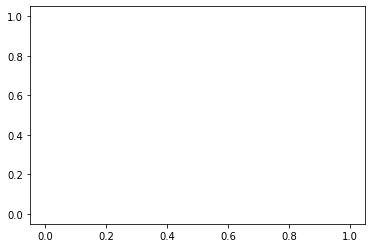

In [8]:
plt.plot(epoch_loss)
plt.show()

In [9]:
### Because we use dropout, train accuracy in eval mode may differ significantly from train accuracy in train mode

load_model_name = 'model/VAD_DNN_epoch_100.pkl'
model = torch.load(load_model_name)
model.eval()
BATCH_SIZE = 256
train_dataset = data.TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(Y_train))
train_dataloader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

num_correct = 0
num_total = 0
for batch_id, (X_batch, Y_batch) in enumerate(train_dataloader):
    X_batch, Y_batch = autograd.Variable(X_batch.cuda()), autograd.Variable(Y_batch.cuda())
    _, output = model(X_batch)
    pred = output.data.max(1)[1]
    num_correct += pred.eq(Y_batch.data.view_as(pred)).sum()
    num_total += output.size()[0]
acc = 100.0 * num_correct / num_total
print('Train Acc: {}/{} = {:.4f}%\t'.format(
        num_correct,
        num_total,
        acc))

Train Acc: 293544/327745 = 89.5648%	


In [10]:
load_model_name = 'model/VAD_DNN_epoch_100.pkl'
model = torch.load(load_model_name)
model.eval()
BATCH_SIZE = 256
test_dataset = data.TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(Y_test))
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

num_correct = 0
num_total = 0
for batch_id, (X_batch, Y_batch) in enumerate(test_dataloader):
    X_batch, Y_batch = autograd.Variable(X_batch.cuda()), autograd.Variable(Y_batch.cuda())
    _, output = model(X_batch)
    pred = output.data.max(1)[1]
    num_correct += pred.eq(Y_batch.data.view_as(pred)).sum()
    num_total += output.size()[0]
acc = 100.0 * num_correct / num_total
print('Test Acc: {}/{} = {:.4f}%\t'.format(
        num_correct,
        num_total,
        acc))

Test Acc: 8961/10000 = 89.6100%	


In [46]:
voice_sample_dir = 'dataset/text-dependent/'
lawrence_sample_files = []
for roots, dirs, files in os.walk(voice_sample_dir):
    for file in files:
        if file.startswith('lawrence') and file.endswith('m4a'):
            lawrence_sample_files.append(file)
print(lawrence_sample_files)
loaded_files = []
for filename in lawrence_sample_files:
    filename = os.path.join(voice_sample_dir, filename)
    y, sr = librosa.load(filename)
    loaded_files.append(np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T,axis=0))
loaded_files = np.array(loaded_files)
print(loaded_files.shape)

['lawrence-13.m4a', 'lawrence-9.m4a', 'lawrence-5.m4a', 'lawrence-11.m4a', 'lawrence-1.m4a', 'lawrence-3.m4a', 'lawrence-6.m4a', 'lawrence-4.m4a', 'lawrence-2.m4a', 'lawrence-14.m4a', 'lawrence-15.m4a', 'lawrence-8.m4a', 'lawrence-12.m4a', 'lawrence-7.m4a', 'lawrence-10.m4a']


/home/lawrence/workspace/pytorchenv/lib/python3.6/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/lawrence/workspace/pytorchenv/lib/python3.6/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/lawrence/workspace/pytorchenv/lib/python3.6/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/lawrence/workspace/pytorchenv/lib/python3.6/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/lawrence/workspace/pytorchenv/lib/python3.6/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread

(15, 40)


In [37]:
loaded_files = np.array(loaded_files)
print(loaded_files.shape)

enrollment_set = loaded_files[:12]
utterance_set = loaded_files[12:]

(15, 40)


In [38]:
load_model_name = 'model/VAD_DNN_epoch_100.pkl'
model = torch.load(load_model_name)
model.eval()

VADDNN(
  (linear_1): Linear(in_features=40, out_features=256, bias=True)
  (linear_2): Linear(in_features=256, out_features=256, bias=True)
  (linear_3): Linear(in_features=256, out_features=256, bias=True)
  (linear_4): Linear(in_features=256, out_features=256, bias=True)
  (linear_5): Linear(in_features=256, out_features=496, bias=True)
  (dropout_1): Dropout(p=0.5, inplace=False)
  (dropout_2): Dropout(p=0.5, inplace=False)
)

In [39]:
train_dataset = data.TensorDataset(torch.FloatTensor(enrollment_set))
train_dataloader = data.DataLoader(train_dataset, batch_size=12, shuffle=False)
with torch.no_grad():
    for batch_id, (X_enrollment,) in enumerate(train_dataloader):
        X_enrollment = X_enrollment.cuda()
        enrollment_output, output = model(X_enrollment)
enrollment_output = enrollment_output.cpu().numpy()
enrollment_embedding = np.mean(enrollment_output, axis=0)

In [40]:
voice_sample_dir = 'dataset/text-dependent/'
josh_sample_files = []
for roots, dirs, files in os.walk(voice_sample_dir):
    for file in files:
        if file.startswith('josh') and file.endswith('m4a'):
            josh_sample_files.append(file)
josh_files = []
for filename in josh_sample_files:
    filename = os.path.join(voice_sample_dir, filename)
    y, sr = librosa.load(filename)
    josh_files.append(np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T,axis=0))
josh_files = np.array(josh_files)
print(josh_files.shape)

utterance_test_set = np.vstack([josh_files, utterance_set])
print(utterance_test_set.shape)

/home/lawrence/workspace/pytorchenv/lib/python3.6/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/lawrence/workspace/pytorchenv/lib/python3.6/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/lawrence/workspace/pytorchenv/lib/python3.6/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/lawrence/workspace/pytorchenv/lib/python3.6/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/lawrence/workspace/pytorchenv/lib/python3.6/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread

(10, 40)
(13, 40)


In [41]:
train_dataset = data.TensorDataset(torch.FloatTensor(utterance_test_set))
train_dataloader = data.DataLoader(train_dataset, batch_size=13, shuffle=False)
with torch.no_grad():
    for batch_id, (X_enrollment,) in enumerate(train_dataloader):
        X_enrollment = X_enrollment.cuda()
        enrollment_output, output = model(X_enrollment)
test_output = enrollment_output.cpu().numpy()

In [48]:
cos_distance = []
for utterance in test_output:
    cos_distance.append(spatial.distance.cosine(enrollment_embedding, utterance))
print(cos_distance)
print("Minimum distance for josh utterances vs lawrence embedding is:", np.min(cos_distance[:10]))
print("Maximum distance for lawrence utterance vs lawrence embedding is:", np.max(cos_distance[10:]))
print("")
print("Based on this, we can probably use experimental threshold of 0.20 and still have decent margin for error")

[0.542151153087616, 0.396335244178772, 0.43813949823379517, 0.4419863820075989, 0.6182933747768402, 0.505691260099411, 0.47575628757476807, 0.4808054566383362, 0.4512820839881897, 0.3462369441986084, 0.053267836570739746, 0.11287206411361694, 0.05464053153991699]
Minimum distance for josh utterances vs lawrence embedding is: 0.3462369441986084
Maximum distance for lawrence utterance vs lawrence embedding is: 0.11287206411361694

Based on this, we can probably use experimental threshold of 0.20 and still have decent margin for error
